In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle

In [8]:
# load in the data

bands = ["SBL", "IBL", "SR", "IBH", "SBH"]
data_dict = {}

feature_set = [9, 10, 12]
num_features = len(feature_set) - 1 # context doesn't count
seed = 8

num_layers = 2
num_hidden_features = 16
num_blocks = 4
early_stop_patience = 10

flow_training_id = f"Masked_PRQ_AR_{num_layers}layers_{num_hidden_features}hidden_{num_blocks}blocks_{seed}seed"
flow_training_dir = os.path.join("models", f"{flow_training_id}/")

with open(f"models/{flow_training_id}/flow_samples", "rb") as infile:
    
    data_dict = pickle.load(infile)
    
print(data_dict.keys())

test_sig = np.load("processed_data/test_sig.npy")[:,feature_set]
test_bkg = np.load("processed_data/test_bkg.npy")[:,feature_set]



dict_keys(['SBL', 'IBL', 'SR', 'IBH', 'SBH', 'SB', 'IB', 'SBL_samples', 'SBH_samples', 'SB_samples', 'IBL_samples', 'IBH_samples', 'IB_samples', 'SR_samples'])
(40000, 3)


SBL


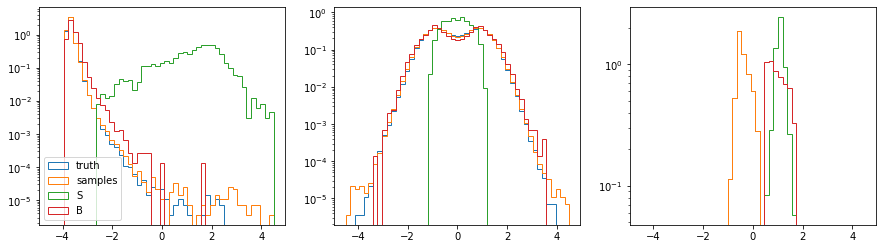

IBL


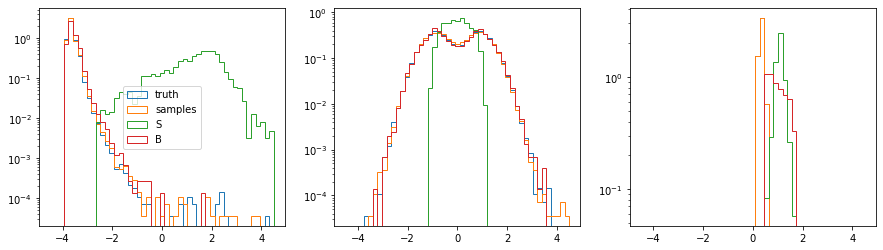

SR


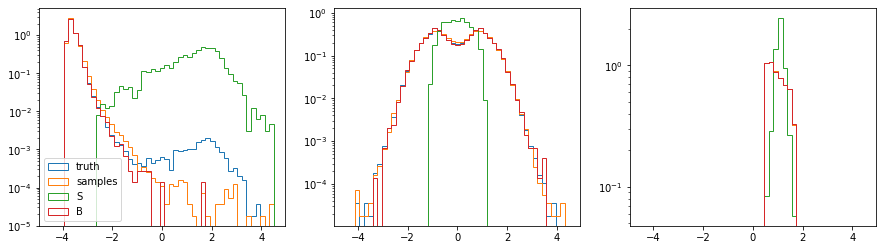

IBH


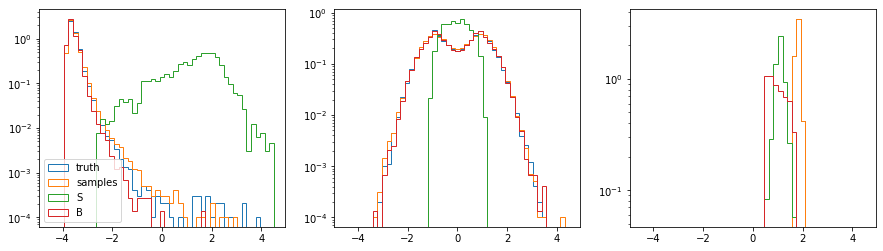

SBH


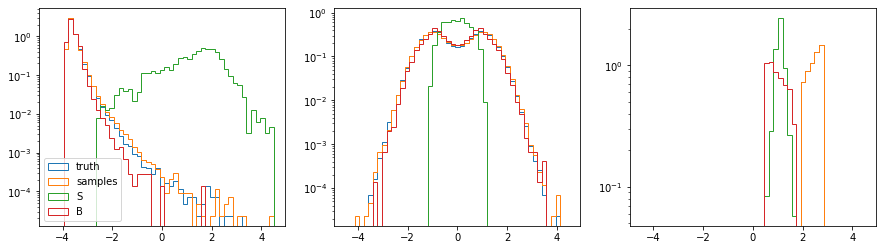

In [9]:
bins = np.linspace(-4.5, 4.5, 50)

for b in bands:
    
    print(b)
    
    
    fig, ax = plt.subplots(1, 3, figsize = (15, 4))
    for i, feature in enumerate(feature_set):
        ax[i].hist(data_dict[b][:,i], bins = bins, label = "truth", histtype = "step", density = "True")
        ax[i].hist(data_dict[f"{b}_samples"][:,i], bins = bins, label = "samples", histtype = "step", density = "true")
        ax[i].hist(test_sig[:,i], bins = bins, label = "S", histtype = "step", density = "True")
        ax[i].hist(test_bkg[:,i], bins = bins, label = "B", histtype = "step", density = "true")
        ax[i].set_yscale("log")
        
    ax[0].legend()
    plt.show()

In [10]:
X_train = np.vstack((data_dict["SR"], data_dict["SR_samples"]))[:,:-1]
Y_train = np.vstack((np.ones((data_dict["SR"].shape[0], 1)), np.zeros((data_dict["SR_samples"].shape[0], 1))))

X_test = np.vstack((test_sig, test_bkg))[:,:-1]
Y_test = np.vstack((np.ones((test_sig.shape[0], 1)), np.zeros((test_bkg.shape[0], 1))))

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(604846, 2) (604846, 1)
(43500, 2) (43500, 1)


In [ ]:
"""
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

print(sum(Y_train==1)/len(Y_train))
"""

Code adapted from https://github.com/mariehein/BackToTheRoots/tree/5619eb225679b1cafe3eaa0d8095bb06007aeb63

In [ ]:
# discrim SR events from SR samples

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_curve, auc


def classifier_training(X_train, Y_train, X_test, Y_test, num_to_ensemble):


    class_weight = {0: 1, 1: sum(Y_train==0)[0]/sum(Y_train==1)[0]}
    class_weights = class_weight[0]*(1.0-Y_train)+class_weight[1]*Y_train
    Y_train = Y_train.reshape(-1,)
    Y_test = Y_test.reshape(-1,)
    class_weights = class_weights.reshape(-1,)

    print("\nTraining class weights: ", class_weight)

    scores = np.zeros((num_to_ensemble,len(X_test)))

    for j in range(num_to_ensemble):
        
        print("Tree number:", j)
        np.random.seed(j+1)
        
        tree = HistGradientBoostingClassifier(verbose=1, max_iter=200, max_leaf_nodes=31, validation_fraction=0.5)
        results_f = tree.fit(X_train, Y_train, sample_weight=class_weights)
        scores[j] = tree.predict_proba(X_test)[:,1]
        
        # plot roc
        fpr, tpr, _ = roc_curve(Y_test, scores[j])
        sic = tpr / np.sqrt(fpr)
        plt.figure()
        plt.plot(tpr, sic)
        plt.xlabel("tpr")
        plt.ylabel("sic")
        plt.show()
        
        
        del results_f
        
    #test_results = np.mean(test_results, axis=0)
    #print("AUC last epoch: %.3f" % pf.plot_roc(test_results, Y_test[:,1],title="roc_classifier_averaging",directory=args.directory))

In [ ]:
classifier_training(X_train, Y_train, X_test, Y_test, 2)